In [1]:
! pip install opencv-python numpy matplotlib scipy

In [2]:
import numpy as np
import cv2 as cv
from scipy import ndimage
import matplotlib.pyplot as plt

In [3]:
# Synthetic image
size = 128
img = np.zeros((size, size, 3))
img[32:96, 32:96] = 1  # white square

# Blue Mask background
mask = img.copy()
mask_bg = np.ones((size, size, 3))
mask_bg[:, :, 0] = 0.0   # Red
mask_bg[:, :, 1] = 0.0   # Green
mask_bg[:, :, 2] = 1.0   # Blue

mask_bg[mask == 1] = 0  # black square

# Green gradient background
bg = np.zeros((size, size, 3))
for i in range(size):
    shade = i / size
    bg[:, i] = [0, 0.6 * shade + 0.2, 0]

# Masked Background

background_masked = bg.copy()
background_masked[mask == 1] = 0

# Final Output - Masked Image
final = bg.copy()
final[mask == 1] = img[mask == 1]

In [4]:
def sobel_edge_detection(image):
    sx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
    
    sy = np.array([[-1,-2,-1],
                   [ 0, 0, 0],
                   [ 1, 2, 1]])
    
    Ix = ndimage.convolve(image, sx, mode="constant")
    Iy = ndimage.convolve(image, sy, mode="constant")
    
    magnitude = np.hypot(Ix, Iy)
    return magnitude / magnitude.max() # Normalize to 0-1

# Final Image - Sobel Edge Detection
img_gray = np.mean(final, axis=2)
edges = sobel_edge_detection(img_gray)

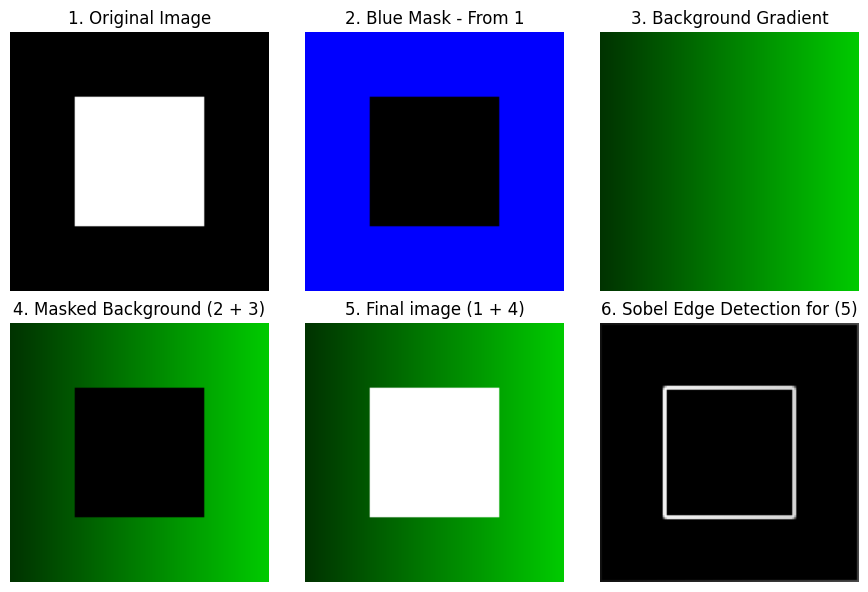

In [5]:
plt.figure(figsize=(9,6))

plt.subplot(231); 
plt.imshow(img); 
plt.title("1. Original Image"); 
plt.axis("off")

plt.subplot(232); 
plt.imshow(mask_bg); 
plt.title("2. Blue Mask - From 1"); 
plt.axis("off")

plt.subplot(233); 
plt.imshow(bg); 
plt.title("3. Background Gradient"); 
plt.axis("off")

plt.subplot(234); 
plt.imshow(background_masked); 
plt.title("4. Masked Background (2 + 3)"); 
plt.axis("off")

plt.subplot(235); 
plt.imshow(final); 
plt.title("5. Final image (1 + 4)"); 
plt.axis("off")

plt.subplot(236); 
plt.imshow(edges, cmap="gray"); 
plt.title("6. Sobel Edge Detection for (5)"); 
plt.axis("off")

plt.tight_layout()
plt.show()

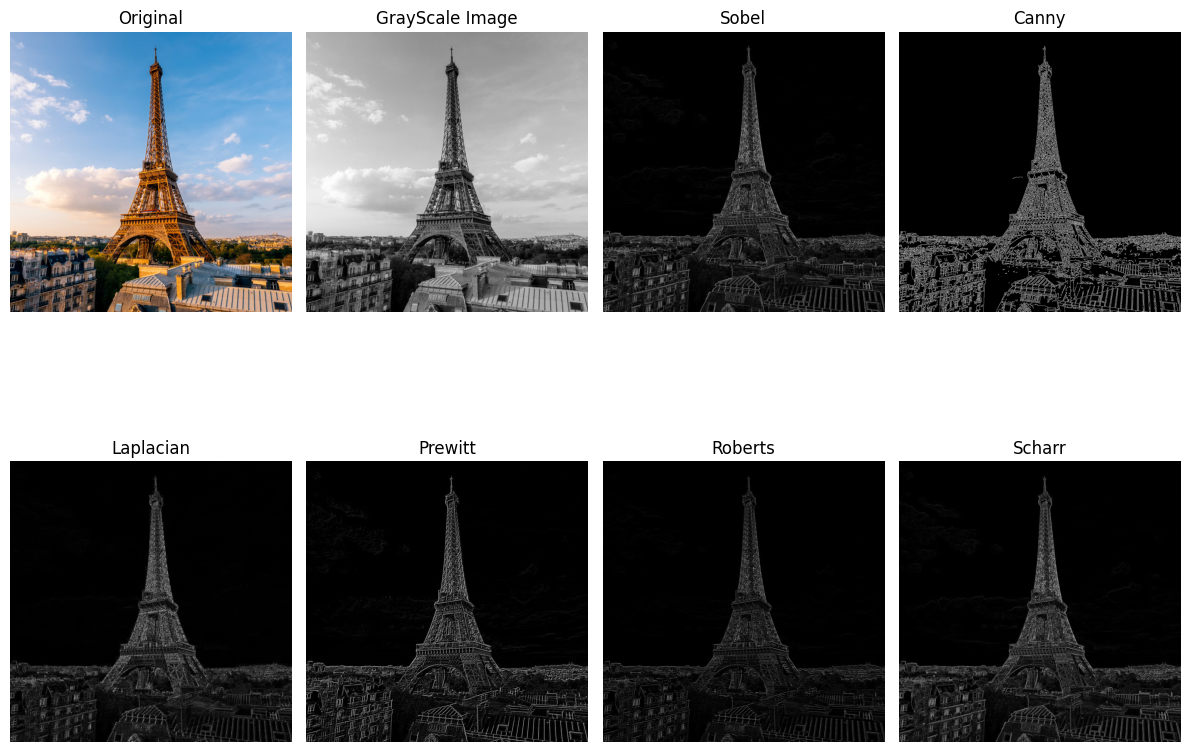

In [6]:
# Load image
image = cv.imread('eiffel_tower.png')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)


# 1. Sobel Edge Detection
sobelx = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=3)
sobely = cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=3)
sobel = cv.magnitude(sobelx, sobely)


# 2. Canny Edge Detection
canny = cv.Canny(gray, 100, 200)


# 3. Laplacian Edge Detection
laplacian = cv.Laplacian(gray, cv.CV_64F)
laplacian = np.absolute(laplacian)
laplacian = np.uint8(laplacian)


# 4. Prewitt Edge Detection
kernelx = np.array([[1,0,-1],
                    [1,0,-1],
                    [1,0,-1]])
kernely = np.array([[1,1,1],
                    [0,0,0],
                    [-1,-1,-1]])

prewittx = cv.filter2D(gray, -1, kernelx)
prewitty = cv.filter2D(gray, -1, kernely)
prewitt = cv.magnitude(np.float32(prewittx), np.float32(prewitty))


# 5. Roberts Cross Edge Detection
kernelx = np.array([[1, 0],
                    [0,-1]])
kernely = np.array([[0, 1],
                    [-1,0]])

robertsx = cv.filter2D(gray, -1, kernelx)
robertsy = cv.filter2D(gray, -1, kernely)
roberts = cv.magnitude(np.float32(robertsx), np.float32(robertsy))


# 6. Scharr Edge Detection
scharrx = cv.Scharr(gray, cv.CV_64F, 1, 0)
scharry = cv.Scharr(gray, cv.CV_64F, 0, 1)
scharr = cv.magnitude(scharrx, scharry)


# Display
titles = ["Original", "GrayScale Image", "Sobel", "Canny",
          "Laplacian", "Prewitt", "Roberts", "Scharr"]

images = [image, gray, sobel, canny,
          laplacian, prewitt, roberts, scharr]

plt.figure(figsize=(12,10))
for i in range(len(images)):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [7]:
def hough_line_detection(edges, theta_step=1, threshold_ratio=0.5):
    
    h, w = edges.shape
    diag = int(np.ceil(np.sqrt(h*h + w*w)))

    rhos = np.arange(-diag, diag + 1)
    thetas = np.deg2rad(np.arange(-90, 90, theta_step))

    accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)

    y_idxs, x_idxs = np.nonzero(edges)

    for x, y in zip(x_idxs, y_idxs):
        for t_idx, theta in enumerate(thetas):
            rho = int(round(x*np.cos(theta) + y*np.sin(theta))) + diag
            accumulator[rho, t_idx] += 1

    # Detect peaks
    threshold = threshold_ratio * accumulator.max()
    rho_idxs, theta_idxs = np.where(accumulator >= threshold)

    lines = [(rhos[r], thetas[t]) for r, t in zip(rho_idxs, theta_idxs)]

    return lines, accumulator

Detected lines (rho, theta in radians):
(np.int64(-55), np.float64(-1.5707963267948966))
(np.int64(-54), np.float64(-1.5533430342749532))
(np.int64(-27), np.float64(-1.5707963267948966))
(np.int64(-26), np.float64(-1.5533430342749532))
(np.int64(26), np.float64(-0.017453292519943295))
(np.int64(27), np.float64(0.0))
(np.int64(28), np.float64(0.017453292519943295))
(np.int64(28), np.float64(1.5533430342749532))
(np.int64(54), np.float64(-0.017453292519943295))
(np.int64(55), np.float64(0.0))
(np.int64(56), np.float64(0.017453292519943295))
(np.int64(56), np.float64(1.5533430342749532))


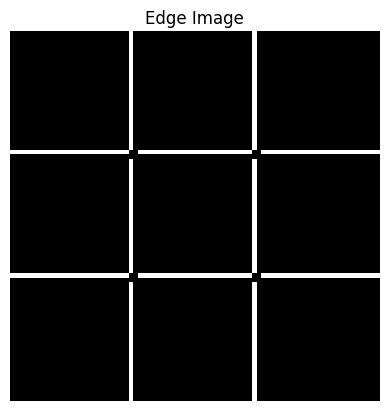

In [8]:
# ---- Example with real image ----
image = cv.imread('chessboard 84x84.png')

gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
blur = cv.GaussianBlur(gray, (3,3), 0)
edges = cv.Canny(blur, 30, 30)

lines, acc = hough_line_detection(edges)

print("Detected lines (rho, theta in radians):")
for l in lines:
    print(l)


# ---- Visualize edges ----
plt.imshow(edges, cmap='gray')
plt.title("Edge Image")
plt.axis("off")
plt.show()

In [9]:
# Harris Corner Detection

def harris_corner_detection(image, sigma=1.5, k=0.05, thresh_factor=0.01):
    
    # Convert image
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY) / 255.0

    # Gradients
    Ix = ndimage.sobel(gray, axis=1)
    Iy = ndimage.sobel(gray, axis=0)

    # Structure tensor smoothing
    Ix2 = ndimage.gaussian_filter(Ix**2, sigma)
    Iy2 = ndimage.gaussian_filter(Iy**2, sigma)
    Ixy = ndimage.gaussian_filter(Ix*Iy, sigma)

    # Harris response
    det = Ix2 * Iy2 - Ixy**2
    trace = Ix2 + Iy2
    R = det - k * trace**2

    # Normalize response (visualization)
    R_norm = cv.normalize(R, None, 0, 255, cv.NORM_MINMAX)
    R_norm = np.uint8(R_norm)

    # Thresholding
    threshold = thresh_factor * R.max()
    R_thresh = np.zeros_like(R)
    R_thresh[R > threshold] = 255

    # Corner coordinates
    corners = np.argwhere(R > threshold)

    return image_rgb, R_norm, R_thresh, corners

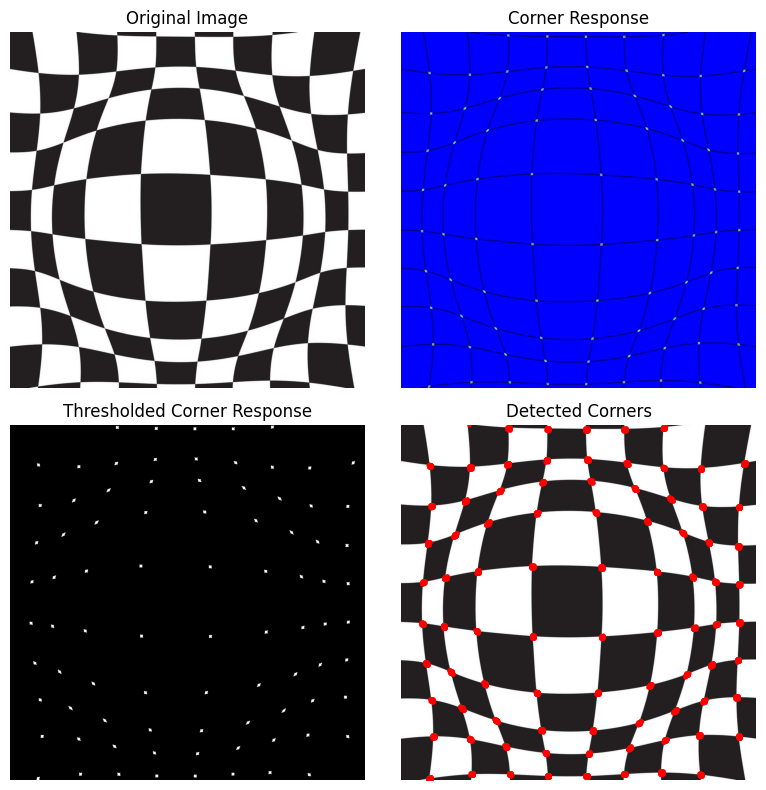

In [10]:
# ---- Load Image ----
image = cv.imread('Checkers.png')

# ---- Run Function ----
image_rgb, R_norm, R_thresh, corners = harris_corner_detection(image)


# ---- Display Outputs ----
plt.figure(figsize=(8,8))

plt.subplot(2,2,1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(R_norm, cmap="jet", vmin=40, vmax=255)
plt.title("Corner Response")
plt.axis("off")

plt.subplot(2,2,3)
plt.imshow(R_thresh, cmap="gray")
plt.title("Thresholded Corner Response")
plt.axis("off")

plt.subplot(2,2,4)
plt.imshow(image_rgb)
plt.plot(corners[:,1], corners[:,0], 'r.', markersize=4)
plt.title("Detected Corners")
plt.axis("off")

plt.tight_layout()
plt.show()